In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/House/data/train.csv"
!cat "/content/drive/My Drive/Colab Notebooks/House/data/train.csv"

'/content/drive/My Drive/Colab Notebooks/House/data/train.csv'
Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,

In [3]:
import os
%cd /content/drive/My Drive/Colab Notebooks/House
os.getcwd()

/content/drive/My Drive/Colab Notebooks/House


'/content/drive/My Drive/Colab Notebooks/House'

In [4]:
#https://iter01.com/419997.html
import pandas as pd
import numpy as np
from datetime import datetime
data_path = 'data/'

In [5]:
train_data = pd.read_csv(data_path+'train.csv', index_col=0) #https://tw511.com/a/01/8965.html
test_data = pd.read_csv(data_path+'test.csv', index_col=0)

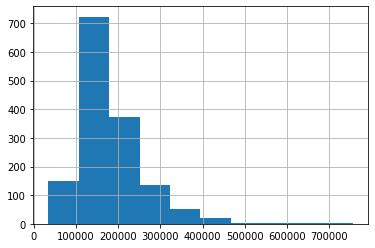

In [6]:
#資料預處理
y_train = train_data.pop('SalePrice')
y_train.hist()

由此可見資料並不平滑，因此需要將其正態化，正態化可以使資料變得平滑，目的是穩定方差，直線化，使資料分佈正態或者接近正態。正態化可以用 numpy 的 log1p() 處理。log1p(y_train) 可以理解為 log 1 plus，即 log（y_train + 1）。正態化之前，先看一下如果正態化之後的價格分佈。

In [7]:
y_train = np.log1p(y_train)

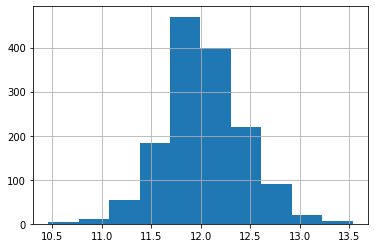

In [8]:
y_train.hist()

將去掉 SalePrice 的訓練集和測試集合並

In [9]:
data = pd.concat((train_data, test_data), axis=0)
data.shape

(2919, 79)

特徵處理

In [10]:
#算出跟售出房子的時間差，並新生成單獨的列，然後刪除這些年份
data.eval('Built2Sold = YrSold-YearBuilt', inplace=True)
data.eval('Add2Sold = YrSold-YearRemodAdd', inplace=True)
data.eval('GarageBlt = YrSold-GarageYrBlt', inplace=True)
data.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [11]:
#這三個相當於是等級和類別，只不過是用數字來當等級的高低而已。因此我們要把這些轉換成 string
data['OverallQual'] = data['OverallQual'].astype(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['MSSubClass'] = data['MSSubClass'].astype(str)

In [12]:
#把category的變數轉變成numerical　
#我們可以用One-Hot的方法來表達category。pandas自帶的get_dummies方法，可以一鍵做到One-Hot。
dummied_data = pd.get_dummies(data)

In [13]:
dummied_data.value_counts()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  Built2Sold  Add2Sold  GarageBlt  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  Utilities_NoSeWa  LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl

In [14]:
#處理numerical變數,category變數處理好了之後，就該輪到numerical變數了。檢視一下缺失值情況。
dummied_data.isnull().sum().sort_values(ascending=False).head()


LotFrontage     486
GarageBlt       159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
dtype: int64

In [15]:
#對於缺失值，需要進行填充，可以使用平均值進行填充。
mean_cols = dummied_data.mean()
dummied_data = dummied_data.fillna(mean_cols)

In [16]:
#標準差標準化
#http://calcgospel.in/wp-content/uploads/2016/12/%E6%A8%99%E6%BA%96%E5%B7%AE%E8%88%87%E6%A8%99%E6%BA%96%E5%8C%96.pdf
numerical_cols = data.columns[data.dtypes != 'object']  # 資料為數值型的列名
num_cols_mean = dummied_data.loc[:, numerical_cols].mean()
num_cols_std = dummied_data.loc[:, numerical_cols].std()
dummied_data.loc[:, numerical_cols] = (dummied_data.loc[:, numerical_cols] - num_cols_mean) / num_cols_std

In [17]:
X_train = dummied_data.loc[train_data.index].values
X_test = dummied_data.loc[test_data.index].values

In [25]:
#建模預測,調參
params = [6,7,8]
scores = []
import xgboost as xgb

from sklearn.model_selection import cross_val_score
for param in params:
    model = xgb.XGBRegressor(max_depth=param)
    score = np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    scores.append(np.mean(score))



[15:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

NameError: ignored

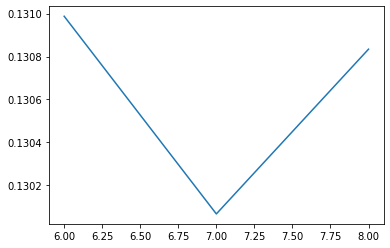

In [26]:
import matplotlib.pyplot as plt
plt.plot(params, scores)
